#### 2 Coupled Classical Oscillators

In [1]:
from classiq import *
from classiq.execution import ExecutionPreferences
import numpy as np
import matplotlib.pyplot as plt
# from qiskit.quantum_info import SparsePauliOp


In [30]:
### Providing all inputs for a 2 coupled SHO case and performing all the initial transformations

N=2 
m= int(N*N)  # required for constructing B and y (value of m taken from the paper)

#masses
M_1= 2 
M_2= 1

#spring constants
k_11=1
k_22=1
k_12=1 

#initial conditions 
initial_positions = np.array([[0], [1]])
initial_velocities= np.array([[0],[0]])

# Force matrix

F= np.array([[k_11+k_12, -k_12], [-k_12, k_12+k_22]])

# Mass matrix

M= np.array([[M_1, 0], [0, M_2]])

rootM= np.sqrt(M)
rootM_inverse= np.linalg.inv(rootM) 

# Computing the matrix A
A = np.linalg.multi_dot([rootM_inverse, F, rootM_inverse])

# print(A)
# Transform coordinates

y_initial= np.matmul(rootM, initial_positions)
ydot_initial= np.matmul(rootM, initial_velocities)

# Perform Cholesky decomposition to get the lower triangular matrix B
B = np.linalg.cholesky(A)

# Stacking L with zeroes to get B to be of the order of N*((N(N+1)/2))
padded_B = np.zeros((m, m))
padded_B[:2, :2] = B

H = -np.block([[np.zeros((padded_B.shape[0], padded_B.shape[0])), padded_B], [padded_B.conj().T, np.zeros((padded_B.shape[1], padded_B.shape[1]))]])

print('Padded B matrix:', padded_B)
print('Hamiltonian formed:', H)

# B transpose matrix, useful for initial state amplitudes and padding the initial y vector (for multiplying it with B dagger)

padded_y_vector = np.pad(y_initial, ((0, m-N), (0, 0)), mode='constant', constant_values=0)
B_transpose= np.transpose(padded_B)

lower_init_amp= complex(0,1) * np.matmul(B_transpose, padded_y_vector)
lower_init_amp


Padded B matrix: [[ 1.          0.          0.          0.        ]
 [-0.70710678  1.22474487  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Hamiltonian formed: [[-0.         -0.         -0.         -0.         -1.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.          0.70710678 -1.22474487
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-1.          0.70710678 -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -1.22474487 -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]]


array([[-0.-0.70710678j],
       [ 0.+1.22474487j],
       [ 0.+0.j        ],
       [ 0.+0.j        ]])

In [35]:
from itertools import product

from numpy import kron

Paulidict = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


# generate all combinations of Pauli strings of size n
def generate_all_pauli_strings(seq, n):
    for s in product(seq, repeat=n):
        yield "".join(s)


# convert a Paulistring of size n to 2**n X 2**n matrix
def pauli_string_2mat(seq):
    myPmat = Paulidict[seq[0]]
    for p in seq[1:]:
        myPmat = kron(myPmat, Paulidict[p])
    return myPmat


# Hilbert-Schmidt-Product of two matrices M1, M2
def hilbert_schmidt(M1, M2):
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

# Naive decomposition, running over all HS products for all Pauli strings
def lcu_naive(H):
    assert H.shape[0] == H.shape[1], "matrix is not square"
    assert H.shape[0] != 0, "matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    myPualiList = list(generate_all_pauli_strings("IZXY", n))

    mylist = []

    for pstr in myPualiList:
        co = (1 / 2**n) * hilbert_schmidt(pauli_string_2mat(pstr), H)
        if co != 0:
            mylist = mylist + [(pstr, co)]

    return mylist


pauli_list= lcu_naive(H)
pauli_list

[('XII', (-0.5561862178478972+0j)),
 ('XIZ', (0.05618621784789726+0j)),
 ('XIX', (0.1767766952966369+0j)),
 ('XZI', (-0.5561862178478972+0j)),
 ('XZZ', (0.05618621784789726+0j)),
 ('XZX', (0.1767766952966369+0j)),
 ('YIY', (0.1767766952966369+0j)),
 ('YZY', (0.1767766952966369+0j))]

In [36]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

# pauli_list_to_hamiltonian(pauli_list)


[struct_literal(PauliTerm, pauli=[Pauli.X, Pauli.I, Pauli.I], coefficient=-0.5561862178478972),
 struct_literal(PauliTerm, pauli=[Pauli.X, Pauli.I, Pauli.Z], coefficient=0.05618621784789726),
 struct_literal(PauliTerm, pauli=[Pauli.X, Pauli.I, Pauli.X], coefficient=0.1767766952966369),
 struct_literal(PauliTerm, pauli=[Pauli.X, Pauli.Z, Pauli.I], coefficient=-0.5561862178478972),
 struct_literal(PauliTerm, pauli=[Pauli.X, Pauli.Z, Pauli.Z], coefficient=0.05618621784789726),
 struct_literal(PauliTerm, pauli=[Pauli.X, Pauli.Z, Pauli.X], coefficient=0.1767766952966369),
 struct_literal(PauliTerm, pauli=[Pauli.Y, Pauli.I, Pauli.Y], coefficient=0.1767766952966369),
 struct_literal(PauliTerm, pauli=[Pauli.Y, Pauli.Z, Pauli.Y], coefficient=0.1767766952966369)]

In [58]:
@qfunc
def main(state: Output[QArray[QBit]]) -> None:
    allocate(len(pauli_list[0][0]), state)
    exponentiation_with_depth_constraint(
        pauli_list_to_hamiltonian(pauli_list),
        evolution_coefficient=10,
        max_depth=500,
        qbv=state,
        )
    
qmod = create_model(main)

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/a3cd29d8-dc3a-44be-a266-cbf22af0232b?version=0.42.2


### Classcal solution using normal modes 

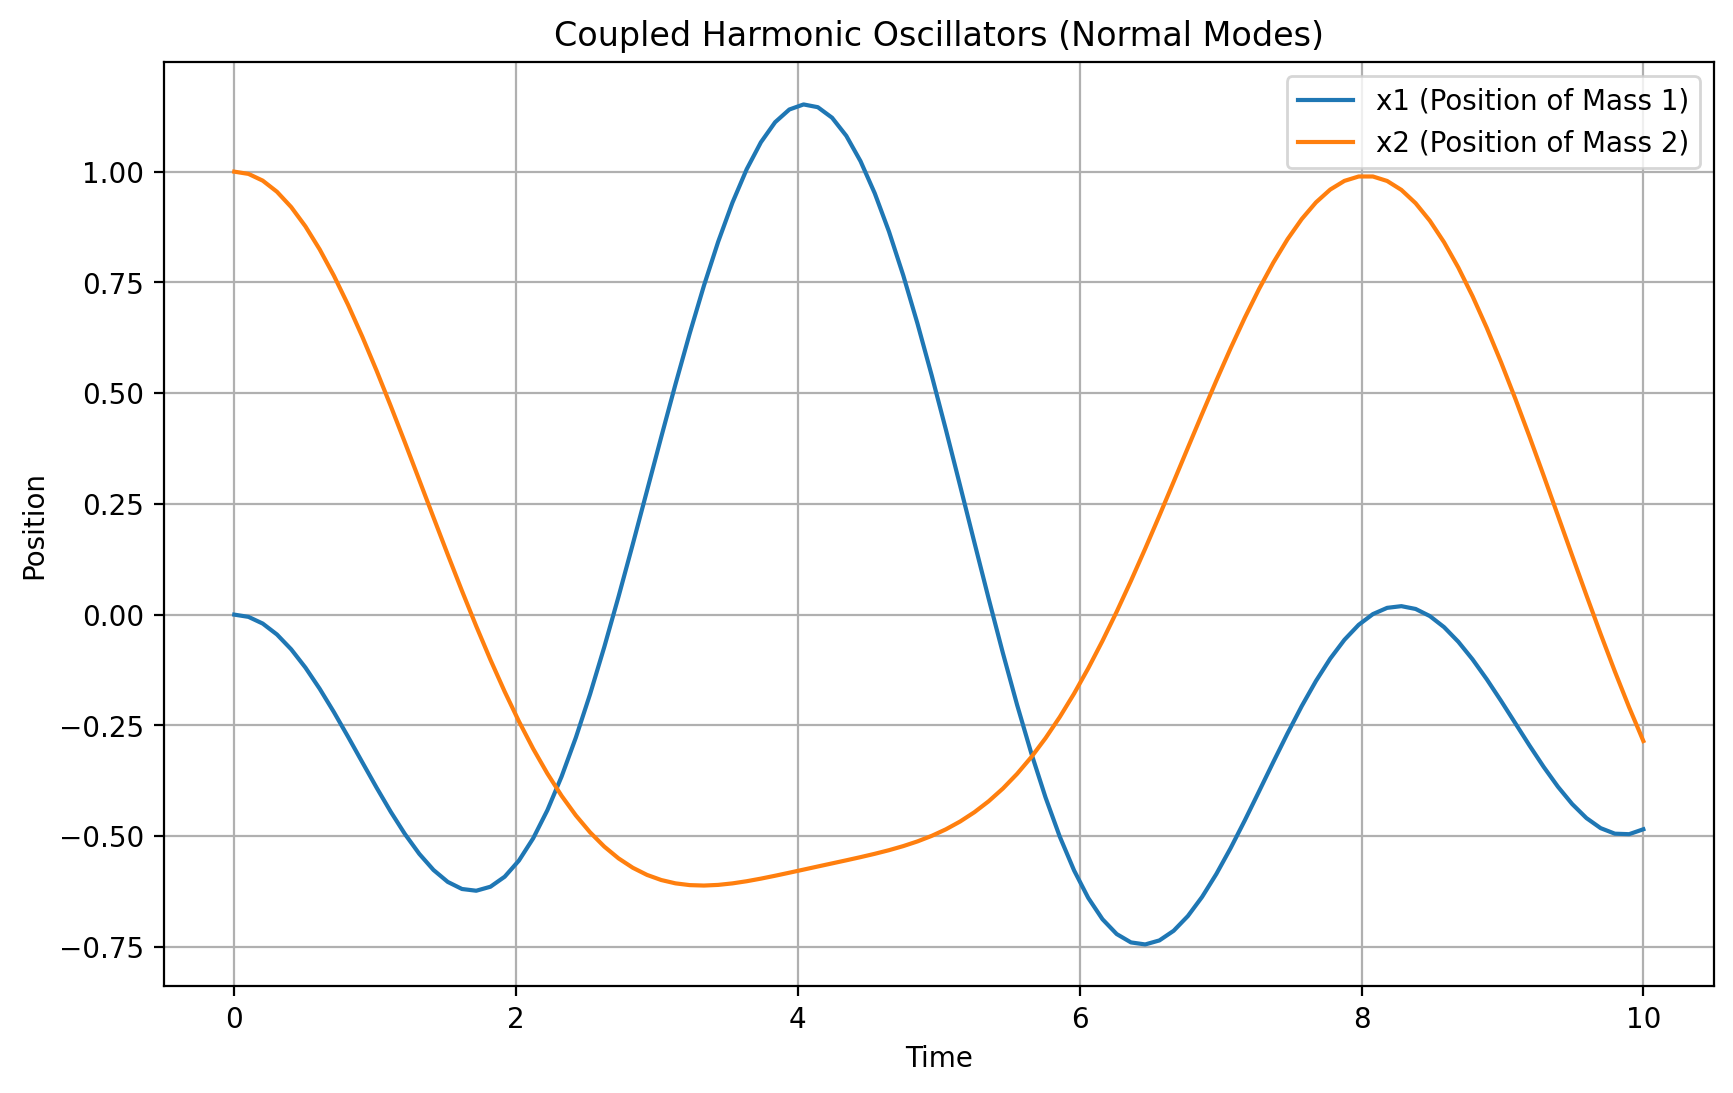

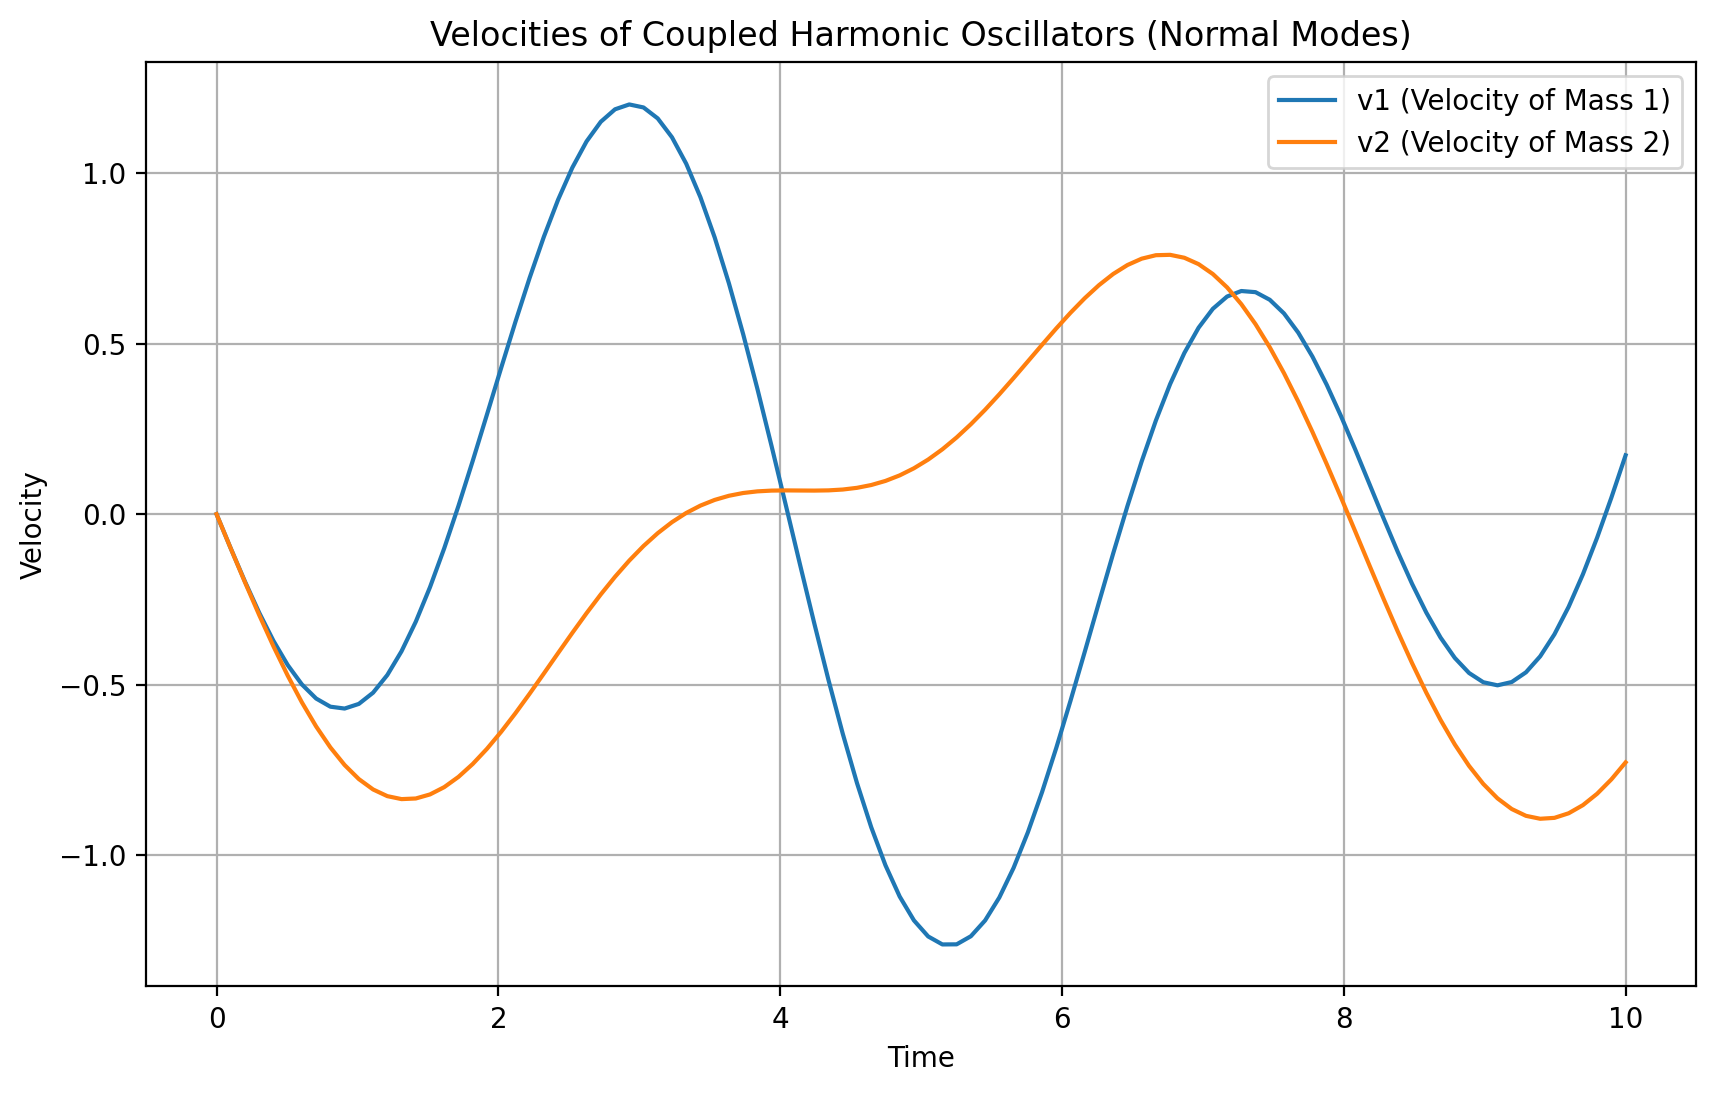

[ 0.         -0.00508852 -0.02019858 -0.04486768 -0.07833806 -0.11957603
 -0.16729836 -0.22000503 -0.27601766 -0.33352261 -0.39061761 -0.44536098
 -0.49582208 -0.54013172 -0.5765315  -0.60342054 -0.61939883 -0.62330576
 -0.61425309 -0.59165152 -0.55523012 -0.50504805 -0.44149852 -0.36530452
 -0.27750666 -0.17944324 -0.07272301  0.04080869  0.15910971  0.27998582
  0.4011393   0.52022036  0.63488006  0.74282353  0.84186223  0.92996406
  1.00529995  1.06628612  1.11162065  1.14031385  1.15171138  1.14550979
  1.12176403  1.08088674  1.02363932  0.95111503  0.86471453  0.76611435
  0.65722911  0.5401684   0.41718925  0.29064543  0.16293462  0.03644493
 -0.08649826 -0.20368358 -0.31306217 -0.41279196 -0.50127699 -0.57720058
 -0.63955184 -0.68764471 -0.72112919 -0.73999459 -0.74456461 -0.73548449
 -0.71370066 -0.68043314 -0.63714173 -0.58548651 -0.52728393 -0.4644593
 -0.39899704 -0.33288984 -0.26808794 -0.20644983 -0.1496956  -0.09936392
 -0.05677391 -0.02299264  0.00119085  0.01528435  0.

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m1 = 2.0  # Mass of first oscillator
m2 = 1.0  # Mass of second oscillator
k1 = 1.0  # Spring constant for first oscillator
k2 = 1.0  # Spring constant for second oscillator
k12 = 1.0  # Coupling spring constant

# Calculate the coefficients of the quadratic equation for omega^2 (obtained from eigenvalue equation)

a = m1 * m2
b = -(m1 * (k2 + k12) + m2 * (k1 + k12))
c = (k1 + k12) * (k2 + k12) - k12 ** 2

# Solve for omega^2 (eigenvalues)
omega_squared = np.roots([a, b, c])
omega1 = np.sqrt(omega_squared[0])
omega2 = np.sqrt(omega_squared[1])

# Calculate the mode shapes (eigenvectors)
A1 = np.array([k1 + k12 - m1 * omega1 ** 2, -k12])
A2 = np.array([k1 + k12 - m1 * omega2 ** 2, -k12])
A1 = A1 / np.linalg.norm(A1)
A2 = A2 / np.linalg.norm(A2)

# Initial conditions
x1_0 = 0.0  # Initial position of first oscillator
v1_0 = 0.0  # Initial velocity of first oscillator
x2_0 = 1.0  # Initial position of second oscillator
v2_0 = 0.0  # Initial velocity of second oscillator

# Initial conditions in terms of normal modes
C = np.linalg.inv(np.array([A1, A2]).T).dot([x1_0, x2_0])
phi1 = 0  # Assume phase angles are zero for simplicity
phi2 = 0

# Time span
t = np.linspace(0, 10, 100)

# Calculate the positions using the normal mode solution
x1 = C[0] * np.cos(omega1 * t + phi1) * A1[0] + C[1] * np.cos(omega2 * t + phi2) * A2[0]
x2 = C[0] * np.cos(omega1 * t + phi1) * A1[1] + C[1] * np.cos(omega2 * t + phi2) * A2[1]

# Calculate the velocities using the normal mode solution
v1 = -C[0] * omega1 * np.sin(omega1 * t + phi1) * A1[0] - C[1] * omega2 * np.sin(omega2 * t + phi2) * A2[0]
v2 = -C[0] * omega1 * np.sin(omega1 * t + phi1) * A1[1] - C[1] * omega2 * np.sin(omega2 * t + phi2) * A2[1]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x1, label='x1 (Position of Mass 1)')
plt.plot(t, x2, label='x2 (Position of Mass 2)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Coupled Harmonic Oscillators (Normal Modes)')
plt.grid()
plt.show()

# Plot the velocity results
plt.figure(figsize=(10, 6))
plt.plot(t, v1, label='v1 (Velocity of Mass 1)')
plt.plot(t, v2, label='v2 (Velocity of Mass 2)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities of Coupled Harmonic Oscillators (Normal Modes)')
plt.grid()
plt.show()

# print(t)
print(x1)
print(x2)

print(v1)
print(v2)
